<center> <h2> Word2vec : </h2> </center>

Imports :

In [1]:
import os
import re
import string
import operator
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from pyemd import emd
from gensim.similarities import WmdSimilarity

Initializations :

In [2]:
# ========== init ==========

path_root = 'for_moodle/'

path_to_data = path_root + 'data/'
path_to_documents = path_root + 'data/documents/'
path_to_plots = path_root
path_to_google_news = path_root

In [3]:
# remove dashes and apostrophes from punctuation marks 
punct = string.punctuation.replace('-', '').replace("'",'')
# regex to match intra-word dashes and intra-word apostrophes
my_regex = re.compile(r"(\b[-']\b)|[\W_]")

In [4]:
# ========== functions ==========

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

# returns the vector of a word
def my_vector_getter(word, wv):
    try:
        # we use reshape because cosine similarity in sklearn now works only for multidimensional arrays
        word_array = wv.wv[word].reshape(1,-1)
        return (word_array)
    except KeyError:
        print('word: <', word, '> not in vocabulary!')

# returns cosine similarity between two word vectors
def my_cos_similarity(word1, word2, wv):
    ## fill the gap ## hint: use the functions my_vector_getter and cosine
    sim = cosine(my_vector_getter(word1,wv), my_vector_getter(word2,wv))
    return round(float(sim),4)
    
def clean_string(string, punct=punct, my_regex=my_regex, to_lower=False):
    if to_lower:
        string = string.lower()
    # remove formatting
    str = re.sub('\s+', ' ', string)
     # remove punctuation
    str = ''.join(l for l in str if l not in punct)
    # remove dashes that are not intra-word
    str = my_regex.sub(lambda x: (x.group(1) if x.group(1) else ' '), str)
    # strip extra white space
    str = re.sub(' +',' ',str)
    # strip leading and trailing white space
    str = str.strip()
    return str

In [5]:
# ========== load and preprocess documents ==========

with open(path_to_data + 'smart_stopwords.txt', 'r') as my_file: 
    stpwds = my_file.read().splitlines()

doc_names = os.listdir(path_to_documents)
doc_names.sort(key=natural_keys)
docs = []

for idx,name in enumerate(doc_names):
    with open(path_to_documents + name,'r') as my_file:
        docs.append(my_file.read())
    if idx % round(len(doc_names)/10) == 0:
        print(idx)

print('documents loaded')

cleaned_docs = []
for idx, doc in enumerate(docs):
    # clean
    doc = clean_string(doc, punct, my_regex, to_lower=True)
    # tokenize (split based on whitespace)
    tokens = doc.split(' ')
    # remove stopwords
    tokens = [token for token in tokens if token not in stpwds]
    # remove digits
    tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
    # remove tokens shorter than 3 characters in size
    tokens = [token for token in tokens if len(token)>2]
    # remove tokens exceeding 25 characters in size
    tokens = [token for token in tokens if len(token)<=25]
    cleaned_docs.append(tokens)
    if idx % round(len(docs)/10) == 0:
        print(idx)

print('documents cleaned')

0
1131
2262
3393
4524
5655
6786
7917
9048
10179
11310
documents loaded
0
1131
2262
3393
4524
5655
6786
7917
9048
10179
11310
documents cleaned


In [6]:
# ========== load Google News word vectors ==========

# create empty word vectors for the words in vocabulary 
my_q = 300 # to match dim of GNews word vectors
mcount = 5
w2v = Word2Vec(size=my_q, min_count=mcount)

# using the build_vocab() method on the right object, with the right argument
w2v.build_vocab(sentences = cleaned_docs)
print('vocab built')

# load vectors corresponding to our vocabulary (takes 1-2 mins)
w2v.intersect_word2vec_format(path_to_google_news + 'GoogleNews-vectors-negative300.bin.gz', binary=True)
print('word vectors loaded')

vocab built
word vectors loaded


In [7]:
# ========== experiment with similarities in embedding space ==========

# two similar words
print('cosine similarity man/woman:', my_cos_similarity('man','woman',w2v))

# two dissimilar words
print('cosine similarity man/road:', my_cos_similarity('man','road',w2v))

# examples of concepts captured in the embedding space:

# gender
queen = my_vector_getter('queen',w2v)
king = my_vector_getter('king',w2v)
man = my_vector_getter('man',w2v)
woman = my_vector_getter('woman',w2v)

operation = king - man + woman
print('cosine similarity (king-man+woman)/queen:', round(float(cosine(operation, queen)),5))

cosine similarity man/woman: 0.7664
cosine similarity man/road: 0.1268
cosine similarity (king-man+woman)/queen: 0.73005


/home/rostom/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


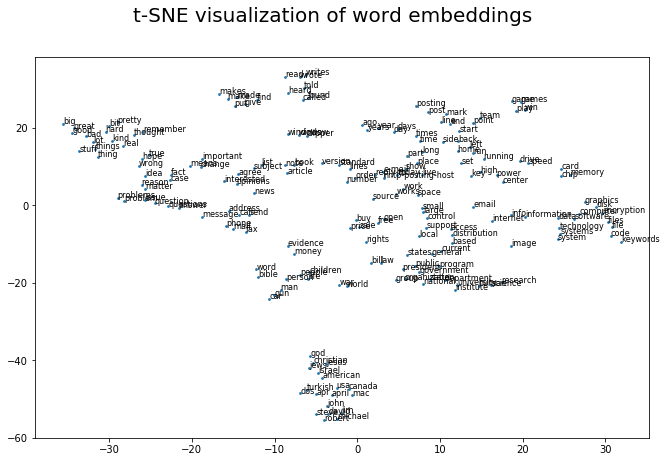

In [8]:
# ========== visualize word embeddings of 'n_mf' most frequent words ==========
# Classification of words :

n_mf = 200
all_tokens = [token for sublist in cleaned_docs for token in sublist]
t_counts = dict(Counter(all_tokens))
sorted_t_counts = sorted(list(t_counts.items()), key=operator.itemgetter(1), reverse=True)
mft = [elt[0] for elt in sorted_t_counts[:n_mf]]

# store the vectors of the most frequent words in np array
mft_vecs = np.empty(shape=(n_mf,my_q))
for idx,token in enumerate(mft):
    #w2v.wv gives you access to the word vectors
    mft_vecs[idx,:] = w2v.wv[token]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10)

mft_vecs_pca = my_pca.fit_transform(mft_vecs)
mft_vecs_tsne = my_tsne.fit_transform(mft_vecs_pca)

fig, ax = plt.subplots()
ax.scatter(mft_vecs_tsne[:,0], mft_vecs_tsne[:,1],s=3)

for x, y, token in zip(mft_vecs_tsne[:,0] , mft_vecs_tsne[:,1], mft):     
    ax.annotate(token, xy=(x, y), size=8)

fig.suptitle('t-SNE visualization of word embeddings',fontsize=20)
fig.set_size_inches(11,7)
fig.savefig(path_to_plots + 'word_embeddings.png',dpi=300)
fig.show()


/home/rostom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  
/home/rostom/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


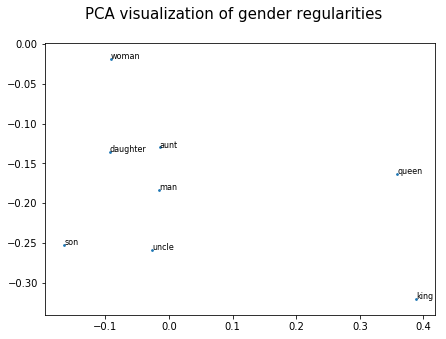

In [9]:
# ========== visualize regularities among word vectors ==========

my_pca = PCA(n_components=2)

# numpy array containg vectors of all words
all_vecs = w2v.wv.syn0
all_vecs_pca = my_pca.fit_transform(all_vecs) 

my_words = ['queen','king','woman','man','uncle','aunt','son','daughter']

# get the row indexes of 'my_words' in 'all_vecs'. Hints: w2v.wv.index2word is a list of words in the order in which they appear in w2v.wv.syn0 - use the .index() method on that list - store results as 'idxs'. You may use a list comprehension.
idxs = [w2v.wv.index2word.index(elt) for elt in my_words]

fig, ax = plt.subplots()
ax.scatter(all_vecs_pca[idxs,0], all_vecs_pca[idxs,1],s=3)
for x, y, token in zip(all_vecs_pca[idxs,0], all_vecs_pca[idxs,1], my_words):     
    ax.annotate(token, xy=(x, y), size=8)
fig.suptitle('PCA visualization of gender regularities',fontsize=15)
fig.set_size_inches(7,5)
fig.savefig(path_to_plots + 'regularities.png',dpi=300)
fig.show()

In [10]:
# ========== document similarity ==========

# 1. in vector space ('bag-of-words' representation)
s_1 = 'computer science is the study of the design and use of computers'
s_2 = 'programming language theory considers various approaches to the description of computation'

s_1 = [elt for elt in s_1.split(' ') if elt not in stpwds]
s_2 = [elt for elt in s_2.split(' ') if elt not in stpwds]

print(s_1)
print(s_2)

features = list(set(s_1).union(set(s_2)))

# project the two sentences in the vector space
p_1 = [1 if feature in s_1 else 0 for feature in features]
p_2 = [1 if feature in s_2 else 0 for feature in features]
p_1_print = list(zip(features, p_1))
p_2_print = list(zip(features, p_2))
print('=== vector space representation of sentence 1: ===')
print(p_1_print)
print('=== vector space representation of sentence 2: ===')
print(p_2_print)

print('similarity of sentences 1 and 2 in vector space:', round(float(cosine(np.array(p_1).reshape(1,-1),np.array(p_2).reshape(1,-1))),5))                

# 2. in word embeddings space 
p_1_embeddings = np.concatenate([my_vector_getter(token,w2v) for token in s_1], axis=0)
p_2_embeddings = np.concatenate([my_vector_getter(token,w2v) for token in s_2], axis=0)

# naive approach: centroids
centroid_1 = np.mean(p_1_embeddings, axis=0).reshape(1,-1)
centroid_2 = np.mean(p_2_embeddings, axis=0).reshape(1,-1)

print('similarity of centroids of sentences 1 and 2 in word embeddings space:', round(float(cosine(centroid_1, centroid_2)),5))

# more principled approach: Word Mover's Distance (Kusner et al. 2015)
#using w2v.wv.wmdistanceT
print('WMD between sentences 1 and 2:', w2v.wv.wmdistance(s_1,s_2) )
print('WMD between sentence 1 and itself:', w2v.wv.wmdistance(s_1, s_1) )
print('WMD between sentence 1 and "the cat sat on the mat":', w2v.wv.wmdistance(s_1, ['cat', 'sat', 'mat']))

['computer', 'science', 'study', 'design', 'computers']
['programming', 'language', 'theory', 'considers', 'approaches', 'description', 'computation']
=== vector space representation of sentence 1: ===
[('science', 1), ('study', 1), ('language', 0), ('approaches', 0), ('programming', 0), ('description', 0), ('computers', 1), ('design', 1), ('considers', 0), ('theory', 0), ('computer', 1), ('computation', 0)]
=== vector space representation of sentence 2: ===
[('science', 0), ('study', 0), ('language', 1), ('approaches', 1), ('programming', 1), ('description', 1), ('computers', 0), ('design', 0), ('considers', 1), ('theory', 1), ('computer', 0), ('computation', 1)]
similarity of sentences 1 and 2 in vector space: 0.0
similarity of centroids of sentences 1 and 2 in word embeddings space: 0.44679
WMD between sentences 1 and 2: 3.551540053045533
WMD between sentence 1 and itself: 0.0
WMD between sentence 1 and "the cat sat on the mat": 3.9315737249755123
